In [1]:
import calliope
import pandas as pd
from building import Building
import geopandas as gpd
import gc
import os
import matplotlib.pyplot as plt
import glob
import warnings

In [2]:
calliope.set_log_verbosity(verbosity='error', include_solver_output=False, capture_warnings=False)
# disable the warnings
warnings.filterwarnings('ignore')

In [ ]:
# plot setting
# set style of plots
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['legend.loc'] = 'lower center'
plt.rcParams['legend.frameon'] = False
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titley'] = 1.03
plt.rcParams['figure.subplot.left'] = 0.08
plt.rcParams['figure.subplot.right'] = 0.95
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.width'] = 2  # setting the x-axis tick width globally
plt.rcParams['ytick.major.width'] = 2 # setting the y-axis tick width globally
# set fig size
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# define a function that optimize one single building
def get_building_model(building_name, building_scenario_folder, yaml_path, store_folder,
                       building_status: pd.Series = None, flatten_spikes=False, flatten_percentile=0.98, 
                       to_lp=False, to_yaml=False, 
                       obj='cost',
                       emission_constraint: ['cost', 'emission']=None):
    building = Building(building_name, building_scenario_folder)
    if flatten_spikes:
        building.flatten_spikes_demand(percentile=flatten_percentile) # flatten the demand spikes
    dict_timeseries_df = {'demand_el': building.app,
                          'demand_sh': building.sh,
                          'demand_dhw': building.dhw,
                          'demand_sc': building.sc,
                          'supply_PV': building.pv_intensity,
                          'supply_PVT_e': building.pvt_e_intensity,
                          'supply_PVT_h': building.pvt_h_relative_intensity,
                          'supply_SCFP': building.scfp_intensity
                          }
    # modify the building_specific_config to match the building's status
    building_specific_config: calliope.AttrDict = calliope.AttrDict.from_yaml(yaml_path)
    building_specific_config.set_key(key='locations.Building.available_area', value=building.area)
    print('the area of building '+building.name+' is '+str(building.area)+' m2')
    building_sub_dict = building_specific_config['locations'].pop('Building')
    building_specific_config['locations'][building.name] = building_sub_dict
    
    # update geothermal storage max capacity
    building_specific_config.set_key(key=f'locations.{building.name}.techs.geothermal_boreholes.constraints.energy_cap_max',
                                     value=(building.area+400)*0.1) # assume 100W/m2 max yield
    if building_status is not None:
        # if building is not in district heating area, delete the district heating technologies keys
        if not building_status['is_disheat']:
            building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_small_heat')
            building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_medium_heat')
            building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_large_heat')
            
        # if building is already equipped with GSHP, set the GSHP purchase cost to 0
        if building_status['already_GSHP']:
            building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.purchase', 0)
            building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.energy_cap', 0)
            
        # if building is already equipped with ASHP, set the ASHP purchase cost to 0
        if building_status['already_ASHP']:
            building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 0)
            building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 0)
            
        # if building is not rebuilt, set GSHP and ASHP costs higher
        if not building_status['is_rebuilt']:
            if not building_status['already_GSHP']:
                building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.purchase', 39934)
                building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.energy_cap', 1316)
            if not building_status['already_ASHP']:
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 18086)
                building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 1360)
                
        # if building is not new, delete the GSHP technology keys
        if not building_status['is_new']:
            building_specific_config.del_key(f'locations.{building.name}.techs.GSHP_heat')
            building_specific_config.del_key(f'locations.{building.name}.techs.GSHP_cooling')
            building_specific_config.del_key(f'locations.{building.name}.techs.geothermal_boreholes')
            
    # # test: delete ASHP
    # building_specific_config.del_key(f'locations.{building.name}.techs.ASHP')
    
    # if emission constraint is not None, add it to the building_specific_config
    if emission_constraint is not None:
        building_specific_config.set_key(key='group_constraints.systemwide_co2_cap.cost_max.co2', value=emission_constraint)
    
    # if obj is cost, set the objective to be cost; if obj is emission, set the objective to be emission
    if obj == 'cost':
        building_specific_config.set_key(key='run.objective_options.cost_class.monetary', value=1)
        building_specific_config.set_key(key='run.objective_options.cost_class.co2', value=0)
    elif obj == 'emission':
        building_specific_config.set_key(key='run.objective_options.cost_class.monetary', value=0)
        building_specific_config.set_key(key='run.objective_options.cost_class.co2', value=1)
    else:
        raise ValueError('obj must be either cost or emission')
    # print current objective setting
    print(building_specific_config.get_key('run.objective_options.cost_class'))
    model = calliope.Model(building_specific_config, timeseries_dataframes=dict_timeseries_df)
    if to_lp:
        model.to_lp(store_folder+'/'+building.name+'.lp')
    if to_yaml:
        model.save_commented_model_yaml(store_folder+'/'+building.name+'.yaml')
    return model
    

In [4]:
# define a function that finds the pareto front of one building regarding cost and emission
def get_pareto_front(epsilon:int, building_name, building_scenario_folder, yaml_path, store_folder,
                     building_status: pd.Series = None, flatten_spikes=False, flatten_percentile=0.98,
                     to_lp=False, to_yaml=False):
    df_pareto = pd.DataFrame(columns=['cost', 'emission'], index=range(epsilon+2))
    # read yaml file and get the list of technologies
    tech_list = calliope.AttrDict.from_yaml(yaml_path).get_key(f'locations.Building.techs').keys()
    df_tech_cap_pareto = pd.DataFrame(columns=tech_list, index=range(epsilon+2))
    # first get the emission-optimal solution
    model_emission = get_building_model(building_name=building_name, building_scenario_folder=building_scenario_folder, 
                                        yaml_path=yaml_path, store_folder=store_folder, 
                                        building_status=building_status, flatten_spikes=flatten_spikes, 
                                        flatten_percentile=flatten_percentile, to_lp=to_lp, to_yaml=to_yaml, 
                                        obj='emission')
    model_emission.run()
    print('emission is done')
    # store the cost and emission in df_pareto
    df_emission = model_emission.get_formatted_array('cost').sel(locs=building_name).to_pandas().transpose().sum(axis=0)
    # add the cost and emission to df_pareto
    df_pareto.loc[0] = [df_emission['monetary'], df_emission['co2']]
    # store the technology capacities in df_tech_cap_pareto
    df_tech_cap_pareto.loc[0] = model_emission.get_formatted_array('energy_cap').to_pandas().iloc[0]
    
    # then get the cost-optimal solution
    model_cost = get_building_model(building_name=building_name, building_scenario_folder=building_scenario_folder, 
                                    yaml_path=yaml_path, store_folder=store_folder, 
                                    building_status=building_status, flatten_spikes=flatten_spikes, 
                                    flatten_percentile=flatten_percentile, to_lp=to_lp, to_yaml=to_yaml, 
                                    obj='cost')
    # run model cost, and find both cost and emission of this result
    model_cost.run()
    print('cost is done')
    # store the cost and emission in df_pareto
    # add epsilon name as row index, start with epsilon_0
    df_cost: pd.DataFrame = model_cost.get_formatted_array('cost').sel(locs=building_name).to_pandas().transpose().sum(axis=0) # first column co2, second column monetary
    # add the cost and emission to df_pareto
    df_pareto.loc[epsilon+1] = [df_cost['monetary'], df_cost['co2']]
    # store the technology capacities in df_tech_cap_pareto
    df_tech_cap_pareto.loc[epsilon+1] = model_cost.get_formatted_array('energy_cap').to_pandas().iloc[0]
    # based on epsilon numbers, create empty rows in df_pareto for further filling

    # then get the epsilon-optimal solution
    # first find out min and max emission, and epsilon emissions are evenly distributed between them
    # if cost and emission optimal have the same emission, then there's no pareto front
    if df_cost['co2'] <= df_emission['co2']:
        print('cost-optimal and emission-optimal have the same emission, no pareto front')
        return df_pareto
    else:
        emission_max =df_cost['co2']
        emission_min =df_emission['co2']
        # calculate the interval between two emissions
        interval = (emission_max - emission_min) / (epsilon+1)
        # for each epsilon, get the epsilon-optimal solution
        for i in range(1, epsilon+1):
            print(f'starting epsilon {i}')
            # set the emission constraint to be emission_min + i * interval
            emission_constraint = emission_min + i * interval
            model_epsilon = get_building_model(building_name=building_name, building_scenario_folder=building_scenario_folder, 
                                               yaml_path=yaml_path, store_folder=store_folder, 
                                               building_status=building_status, flatten_spikes=flatten_spikes, 
                                               flatten_percentile=flatten_percentile, to_lp=to_lp, to_yaml=to_yaml, 
                                               obj='cost', emission_constraint=emission_constraint)
            model_epsilon.run()
            
            print(f'epsilon {i} is done')
            # store the cost and emission in df_pareto
            df_epsilon = model_epsilon.get_formatted_array('cost').sel(locs=building_name).to_pandas().transpose().sum(axis=0)
            # add the cost and emission to df_pareto
            df_pareto.loc[i] = [df_epsilon['monetary'], df_epsilon['co2']]
            # store the technology capacities in df_tech_cap_pareto
            df_tech_cap_pareto.loc[i] = model_epsilon.get_formatted_array('energy_cap').to_pandas().iloc[0]
            
        df_pareto = df_pareto.merge(df_tech_cap_pareto, left_index=True, right_index=True)
        df_pareto = df_pareto.astype({'cost': float, 'emission': float})
        return df_pareto

In [7]:
scenario_folder = r'C:\Users\wangy\OneDrive\ETHY2FW\IDP_Personal\CEA\2050 w3'
zone_gdf = gpd.read_file(scenario_folder+r'\inputs\building-geometry\zone.shp')
# create a new df using only the columns we need
zone_df = pd.DataFrame()
zone_df['Name'] = zone_gdf['Name']
zone_df.index = zone_df['Name']
# delete the Name column in zone_df
zone_df = zone_df.drop(columns='Name')

In [8]:
zone_gdf['area'] = zone_gdf['geometry'].area

In [9]:
# read the csv file containing if the building is inside district area
district_df = pd.read_csv(scenario_folder+r'\inputs\is_disheat.csv', index_col=0)
# merge the two df
zone_df = zone_df.merge(district_df, left_index=True, right_index=True)
# read the csv file containing if building is rebuilt
rebuild_df = pd.read_csv(scenario_folder+r'\inputs\Rebuild.csv', index_col=0)
# merge the two df, but since the zone_df has more columns, if rebuild_df doesn't contain some building, set the value to 0
zone_df = zone_df.merge(rebuild_df, left_index=True, right_index=True, how='left').fillna(0)
# read the csv file containing if the building is renovated
renovate_df = pd.read_csv(scenario_folder+r'\inputs\Renovation.csv', index_col=0)
# merge the two df, but since the zone_df has more columns, if renovate_df doesn't contain some building, set the value to 0
zone_df = zone_df.merge(renovate_df, left_index=True, right_index=True, how='left').fillna(0)
# read dbf file containing current building systems
current_system_df = gpd.read_file(r"C:\Users\wangy\OneDrive\ETHY2FW\IDP_Personal\CEA\2023 Baseline\inputs\building-properties\supply_systems.dbf")
# leave only the type_hs column
current_system_df = current_system_df[['Name', 'type_hs']]
current_system_df.index = current_system_df['Name']
current_system_df = current_system_df.drop(columns='Name')
# merge the two df, but since the zone_df has more columns
zone_df = zone_df.merge(current_system_df, left_index=True, right_index=True, how='left')

In [10]:
# add indicating columns to guide adjusting AttrDict based on building's status
zone_df['is_disheat'] = zone_df['DisHeat'].astype(bool)
zone_df['is_rebuilt'] = zone_df['Rebuild'].astype(bool)
zone_df['is_renovated'] = zone_df['Renovation'].astype(bool)
zone_df['is_new'] = ~zone_df['is_rebuilt'] & ~zone_df['is_renovated']
zone_df['already_GSHP'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS6'
zone_df['already_ASHP'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS7'
zone_df['no_heat'] = zone_df['type_hs'] == 'SUPPLY_HEATING_AS0'

In [11]:
# iterate through the zone_df to create the building objects and store them in a list
building_list = []
# check if building's name is already stored in subfolder result_per_building; if not, add it to the list
for index, row in zone_df.iterrows():
    building_name = index
    if building_name+'_pareto.csv' not in os.listdir('./result_pareto'):
        building_list.append(building_name)
    else:
        print(building_name+' is already done')

B302032606 is already done
B302030812 is already done
B302030808 is already done
B302034645 is already done
B302065793 is already done
B302063706 is already done
B302030809 is already done
B302065100 is already done
B302065112 is already done
B302061111 is already done
B302030821 is already done
B302030810 is already done
B302065787 is already done
B302030823 is already done
B302065980 is already done
B302030817 is already done
B302065792 is already done
B302066525 is already done
B162950 is already done
B302064671 is already done
B302030825 is already done
B302065403 is already done
B302067154 is already done
B3020662121 is already done
B302023109 is already done
B162856 is already done
B302065981 is already done
B302065794 is already done
B302066554 is already done
B162618 is already done
B302030820 is already done
B302065533 is already done
B302066077 is already done
B302066212 is already done
B302062983 is already done
B302066400 is already done
B302065878 is already done
B30202278

In [12]:
test_building_list = [
    # 'B302030807',
                      # 'B302030808', 'B302030809', 'B302030810', 'B302030811', 'B302030812', 'B302030813'
                      ]

In [ ]:
# iterate through the zone_df get pareto front for each building and store output in a dictionary
dict_pareto = {}
for idx, row in zone_df.iterrows():
    # if building already in building_list, skip it
    if idx not in building_list:
        continue
        
    # if building doesn't need heating, skip it
    if row['no_heat']:
        print(idx+' doesn\'t need heating')
        continue
        
    # # if building not having GSHP, skip it
    # if not row['already_GSHP']:
    #     print(idx+' doesn\'t have GSHP')
    #     continue
    
    # # if building not in test_building_list, skip it
    # if idx not in test_building_list:
    #     continue
    
    # if building is not in district heating area, skip it
    df_pareto = get_pareto_front(epsilon=3, building_name=idx, building_scenario_folder=scenario_folder, 
                                                 yaml_path='./data/technology/techs_plot8.yml', store_folder='./result_site_specific_2',
                                                 building_status=zone_df.loc[idx], flatten_spikes=True, flatten_percentile=0.98, 
                                                 to_lp=False, to_yaml=False)
    dict_pareto[idx] = df_pareto
    # save the df_pareto as csv
    df_pareto.to_csv('./result_pareto/'+idx+'_pareto.csv')
    del df_pareto
    print(idx+' is done')
    # clean up the rest of the memory
    gc.collect()

the area of building B162953 is 125.53637990433289 m2
{'co2': 1, 'monetary': 0}
emission is done
the area of building B162953 is 125.53637990433289 m2
{'co2': 0, 'monetary': 1}
cost is done
starting epsilon 1
the area of building B162953 is 125.53637990433289 m2
{'co2': 0, 'monetary': 1}
epsilon 1 is done
starting epsilon 2
the area of building B162953 is 125.53637990433289 m2
{'co2': 0, 'monetary': 1}
epsilon 2 is done
starting epsilon 3
the area of building B162953 is 125.53637990433289 m2
{'co2': 0, 'monetary': 1}
epsilon 3 is done
B162953 is done
the area of building B162948 is 214.29532663796317 m2
{'co2': 1, 'monetary': 0}
emission is done
the area of building B162948 is 214.29532663796317 m2
{'co2': 0, 'monetary': 1}
cost is done
starting epsilon 1
the area of building B162948 is 214.29532663796317 m2
{'co2': 0, 'monetary': 1}
epsilon 1 is done
starting epsilon 2
the area of building B162948 is 214.29532663796317 m2
{'co2': 0, 'monetary': 1}
epsilon 2 is done
starting epsilon 3


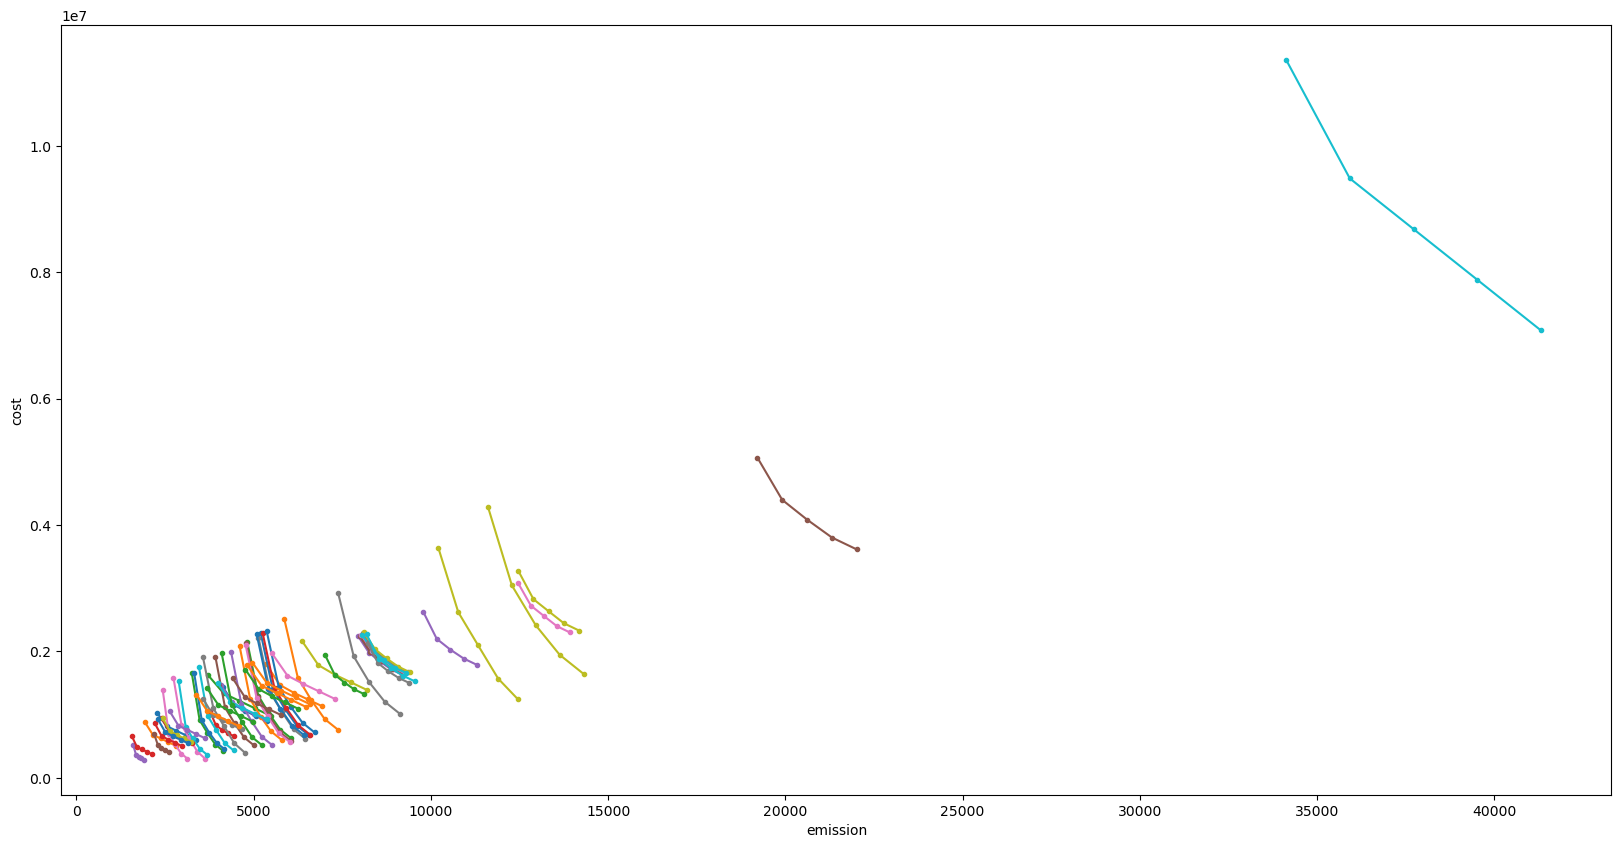

In [6]:
# read all csv files in the subfolder, for every building, and plot the pareto front into one figure
for file in os.listdir('./result_pareto'):
    if not file.endswith('.csv'):
        continue
    df_pareto = pd.read_csv('./result_pareto/'+file, index_col=0)
    plt.plot(df_pareto['emission'], df_pareto['cost'], label=file[:-10], marker='.')
    
plt.ylabel('cost [CHF]')
plt.xlabel('emission [kg]')
plt.title('pareto front for all buildings')
plt.xlim(-200, 16000)
plt.ylim(1e5, 0.5e6)

plt.show()


In [8]:
# get pareto front for building B302030807
df_pareto = get_pareto_front(epsilon=10, building_name='B302030807', building_scenario_folder=scenario_folder, 
                                                 yaml_path='./data/technology/techs_plot8.yml', store_folder='./result_site_specific_2',
                                                 building_status=zone_df.loc['B302030807'], flatten_spikes=True, flatten_percentile=0.98, 
                                                 to_lp=False, to_yaml=False)

the area of building B302030807 is 273.51458448111305 m2
{'co2': 1, 'monetary': 0}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



emission is done
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



cost is done
starting epsilon 1
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



epsilon 1 is done
starting epsilon 2
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



epsilon 2 is done
starting epsilon 3
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



epsilon 3 is done
starting epsilon 4
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



epsilon 4 is done
starting epsilon 5
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



epsilon 5 is done
starting epsilon 6
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



epsilon 6 is done
starting epsilon 7
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



epsilon 7 is done
starting epsilon 8
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



epsilon 8 is done
starting epsilon 9
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



epsilon 9 is done
starting epsilon 10
the area of building B302030807 is 273.51458448111305 m2
{'co2': 0, 'monetary': 1}


C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



epsilon 10 is done


In [143]:
# optimize the building one by one and store them in result_per_building as netcdf files
for idx, row in zone_df.iterrows():
    # if building already in building_list, skip it
    if idx not in building_list:
        continue
        
    # if building doesn't need heating, skip it
    if row['no_heat']:
        print(idx+' doesn\'t need heating')
        continue
        
    # if building not in test_building_list, skip it
    if idx not in test_building_list:
        continue
    # if building is not in district heating area, skip it
    model = get_building_model(building_name=idx, building_scenario_folder=scenario_folder, 
                               yaml_path='./data/technology/techs_plot8.yml', store_folder='./result_site_specific_2',
                               building_status=row, flatten_spikes=True, flatten_percentile=0.98, to_lp=True, to_yaml=True, emission_constraint=None)
    model.run()
    # save to result_per_building, which is a subfolder of current working directory
    model.to_netcdf(path='./result_site_specific_2/'+idx+'.nc')
    # calculate how many percent of the buildings are done, including the current one and its name
    # calculate how many .nc files are in the subfolder, but some files are not .nc files, so len(os.listdir()) is not accurate
    number_of_nc_files = len(glob.glob('./result_site_specific_2/*.nc'))
    print('including '+idx+', '+str(round(number_of_nc_files/len(zone_df.index)*100, 2))+'% of the buildings are done')
    
    del model
    # also delete the instance and the timeseries dataframes to save memory
    del building
    del dict_timeseries_df
    # clean up the rest of the memory
    gc.collect()

B302011886 doesn't need heating
B302012803 doesn't need heating
B302024094 doesn't need heating
B302013071 doesn't need heating
B302024327 doesn't need heating
B302011676 doesn't need heating
B302060757 doesn't need heating
B302024344 doesn't need heating
B302011740 doesn't need heating
B302024101 doesn't need heating
B302011894 doesn't need heating
B302011958 doesn't need heating
B302024497 doesn't need heating
B302012074 doesn't need heating
B302023896 doesn't need heating
B302019762 doesn't need heating
B302024165 doesn't need heating
B302024143 doesn't need heating
B302012488 doesn't need heating
B302011910 doesn't need heating
B302023917 doesn't need heating
B302021222 doesn't need heating
B302011957 doesn't need heating
B302060601 doesn't need heating
B302012080 doesn't need heating
B302024335 doesn't need heating
B302011995 doesn't need heating
B302012558 doesn't need heating
B302024134 doesn't need heating
B302012555 doesn't need heating
B302024146 doesn't need heating
B3020124

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Monetary cost class with a weight of 1 is still included in the objective. If you want to remove the monetary cost class, add `{"monetary": 0}` to the dictionary nested under  `run.objective_options.cost_class`.

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



including B302030807, 2.45% of the buildings are done


NameError: name 'building' is not defined

In [131]:
    building = Building(idx, scenario_folder)
    building.flatten_spikes_demand(percentile=0.98) # flatten the demand spikes
    dict_timeseries_df = {'demand_el': building.app,
                          'demand_sh': building.sh,
                          'demand_dhw': building.dhw,
                          'demand_sc': building.sc,
                          'supply_PV': building.pv_intensity,
                          'supply_PVT_e': building.pvt_e_intensity,
                          'supply_PVT_h': building.pvt_h_relative_intensity,
                          'supply_SCFP': building.scfp_intensity
                          }
    # modify the building_specific_config to match the building's status
    building_specific_config: calliope.AttrDict = calliope.AttrDict.from_yaml('./data/technology/techs_plot8.yml')
    building_specific_config.set_key(key='locations.Building.available_area', value=building.area)
    print('the area of building '+building.name+' is '+str(building.area)+' m2')
    building_sub_dict = building_specific_config['locations'].pop('Building')
    building_specific_config['locations'][building.name] = building_sub_dict
    
    # update geothermal storage max capacity
    building_specific_config.set_key(key=f'locations.{building.name}.techs.geothermal_boreholes.constraints.energy_cap_max',
                                     value=(building.area+400)*0.1) # assume 100W/m2 max yield
    # if building is not in district heating area, delete the district heating technologies keys
    if not row['is_disheat']:
        building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_small_heat')
        building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_medium_heat')
        building_specific_config.del_key(f'locations.{building.name}.techs.DHDC_large_heat')
    
    # if building is already equipped with GSHP, set the GSHP purchase cost to 0
    if row['already_GSHP']:
        building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.purchase', 0)
        building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.energy_cap', 0)
        
    # if building is already equipped with ASHP, set the ASHP purchase cost to 0
    if row['already_ASHP']:
        building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 0)
        building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 0)
    
    # if building is not rebuilt, set GSHP and ASHP costs higher
    if not row['is_rebuilt']:
        if not row['already_GSHP']:
            building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.purchase', 39934)
            building_specific_config.set_key(f'locations.{building.name}.techs.GSHP_heat.costs.monetary.energy_cap', 1316)
        if not row['already_ASHP']:
            building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.purchase', 18086)
            building_specific_config.set_key(f'locations.{building.name}.techs.ASHP.costs.monetary.energy_cap', 1360)
            
        # if building is not new, delete the GSHP technology keys
    if not row['is_new']:
        building_specific_config.del_key(f'locations.{building.name}.techs.GSHP_heat')
        building_specific_config.del_key(f'locations.{building.name}.techs.GSHP_cooling')
        building_specific_config.del_key(f'locations.{building.name}.techs.geothermal_boreholes')
            
    # # test: delete ASHP
    # building_specific_config.del_key(f'locations.{building.name}.techs.ASHP')        
    
    model = calliope.Model(building_specific_config, timeseries_dataframes=dict_timeseries_df)
    model.to_lp('./result_site_specific_2/'+building.name+'.lp')
    model.run()
    model.save_commented_model_yaml('./result_site_specific_2/'+building.name+'.yaml')
    # save to result_per_building, which is a subfolder of current working directory
    model.to_netcdf(path='./result_site_specific_2/'+building.name+'.nc')
    # calculate how many percent of the buildings are done, including the current one and its name
    # calculate how many .nc files are in the subfolder, but some files are not .nc files, so len(os.listdir()) is not accurate
    number_of_nc_files = len(glob.glob('./result_site_specific_2/*.nc'))
    print('including '+building.name+', '+str(round(number_of_nc_files/len(zone_df.index)*100, 2))+'% of the buildings are done')
    
    del model
    # also delete the instance and the timeseries dataframes to save memory
    del building
    del dict_timeseries_df
    # clean up the rest of the memory
    gc.collect()

B302011886 doesn't need heating
B302012803 doesn't need heating
B302024094 doesn't need heating
B302013071 doesn't need heating
B302024327 doesn't need heating
B302011676 doesn't need heating
B302060757 doesn't need heating
B302024344 doesn't need heating
B302011740 doesn't need heating
B302024101 doesn't need heating
B302011894 doesn't need heating
B302011958 doesn't need heating
B302024497 doesn't need heating
B302012074 doesn't need heating
B302023896 doesn't need heating
B302019762 doesn't need heating
B302024165 doesn't need heating
B302024143 doesn't need heating
B302012488 doesn't need heating
B302011910 doesn't need heating
B302023917 doesn't need heating
B302021222 doesn't need heating
B302011957 doesn't need heating
B302060601 doesn't need heating
B302012080 doesn't need heating
B302024335 doesn't need heating
B302011995 doesn't need heating
B302012558 doesn't need heating
B302024134 doesn't need heating
B302012555 doesn't need heating
B302024146 doesn't need heating
B3020124

C:\Users\wangy\miniforge3\envs\calliope\lib\site-packages\calliope\exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Integer and / or binary decision variables are included in this model. This may adversely affect solution time, particularly if you are using a non-commercial solver. To improve solution time, consider changing MILP related solver options (e.g. `mipgap`) or removing MILP constraints.



including B302030807, 2.45% of the buildings are done
B302023923 doesn't need heating
B302011895 doesn't need heating
B302024088 doesn't need heating
B302023895 doesn't need heating
B302066213 doesn't need heating
B302024147 doesn't need heating
B302024345 doesn't need heating
B302062591 doesn't need heating
B302012262 doesn't need heating
B302011847 doesn't need heating
B302024106 doesn't need heating
B302011825 doesn't need heating
B302013030 doesn't need heating
B3020659791 doesn't need heating


In [158]:
# read all the netcdf files in the subfolder, for every building, find the capacity data of the optimal configuration for each building, and store them as a line in a dataframe
energy_cap_df = pd.DataFrame()
for file in os.listdir('./result_site_specific_2'):
    if not file.endswith('.nc'):
        continue
    model = calliope.read_netcdf('./result_site_specific_2/'+file)
    # add the building name as a row index, and all energy_cap values as a row, and don't use append because it's deprecated
    # first define the column names
    if energy_cap_df.empty:
        energy_cap_df = pd.DataFrame(columns=model.get_formatted_array('energy_cap').to_pandas().columns)
    # then add the row
    energy_cap_df.loc[file[:-3]] = model.get_formatted_array('energy_cap').to_pandas().iloc[0]

In [4]:
energy_cap_df = energy_cap_df.fillna(0)

In [19]:
# plot the histogram of PV cap per building area
energy_cap_df['PV_area'] = energy_cap_df['PV'] * 7
energy_cap_df['area'] = zone_gdf['area']

In [25]:
energy_cap_df['techs']

KeyError: 'techs'

In [ ]:
# plot the DHW_to_heat and wood_boiler_DHW fractions using df method
energy_cap_df['fraction_DHW_to_heat'] = energy_cap_df['DHW_to_heat'] / energy_cap_df['wood_boiler_DHW']
energy_cap_df.plot(y='fraction_DHW_to_heat', kind='hist', bins=100)


In [133]:
model = calliope.read_netcdf('./result_site_specific_2/B302030807.nc')

In [65]:
model_energy_cap = model.get_formatted_array('energy_cap').to_pandas().iloc[0]

In [ ]:
model.inputs.cost_purchase.to_pandas().dropna(axis=1)

In [ ]:
model.inputs.cost_energy_cap.to_pandas().dropna(axis=1)

In [ ]:
model.plot.timeseries()

In [134]:
model.results

<xarray.Dataset>
Dimensions:                                 (loc_techs: 18,
                                             loc_tech_carriers_prod: 16,
                                             timesteps: 1460,
                                             loc_tech_carriers_con: 15,
                                             costs: 2, loc_techs_cost: 14,
                                             loc_techs_area: 2,
                                             ...
                                             loc_techs_investment_cost: 12,
                                             loc_techs_purchase: 6,
                                             loc_techs_cost_investment_constraint: 12,
                                             loc_carriers_system_balance_constraint: 6,
                                             loc_techs_balance_demand_constraint: 4,
                                             carriers: 6, techs: 25)
Coordinates: (12/17)
  * techs                                   (techs) object 'ASHP' ... 'wood_s...
  * carriers                                (carriers) object 'DHW' ... 'wood'
  * costs                                   (costs) object 'co2' 'monetary'
  * loc_carriers_system_balance_constraint  (loc_carriers_system_balance_constraint) object ...
  * loc_tech_carriers_con                   (loc_tech_carriers_con) object 'B...
  * loc_tech_carriers_export                (loc_tech_carriers_export) object ...
    ...                                      ...
  * loc_techs_cost_investment_constraint    (loc_techs_cost_investment_constraint) object ...
  * loc_techs_investment_cost               (loc_techs_investment_cost) object ...
  * loc_techs_om_cost                       (loc_techs_om_cost) object 'B3020...
  * loc_techs_purchase                      (loc_techs_purchase) object 'B302...
  * loc_techs_store                         (loc_techs_store) object 'B302030...
  * timesteps                               (timesteps) datetime64[ns] 2050-0...
Data variables: (12/19)
    energy_cap                              (loc_techs) float64 67.35 ... 23.63
    carrier_prod                            (loc_tech_carriers_prod, timesteps) float64 ...
    carrier_con                             (loc_tech_carriers_con, timesteps) float64 ...
    cost                                    (costs, loc_techs_cost) float64 7...
    resource_area                           (loc_techs_area) float64 273.5 0.0
    storage_cap                             (loc_techs_store) float64 0.0 ......
    ...                                      ...
    system_balance                          (loc_carriers_system_balance_constraint, timesteps) float64 ...
    required_resource                       (loc_techs_balance_demand_constraint, timesteps) float64 ...
    capacity_factor                         (timesteps, loc_tech_carriers_prod) float64 ...
    systemwide_capacity_factor              (carriers, techs) float64 0.0 ......
    systemwide_levelised_cost               (carriers, costs, techs) float64 ...
    total_levelised_cost                    (carriers, costs) float64 0.1722 ...
Attributes:
    termination_condition:     optimal
    objective_function_value:  8017.432229433613
    solution_time:             9.57991
    time_finished:             2023-12-12 01:18:24
    calliope_version:          0.6.10
    applied_overrides:         
    scenario:                  None
    defaults:                  carrier_ratios:\ncharge_rate:\nenergy_cap_per_...
    allow_operate_mode:        1
    model_config:              calliope_version: 0.6.10\nname: building in pl...
    run_config:                backend: pyomo\nbigM: 100000000.0\ncyclic_stor...

In [85]:
model_geostore_prod = model.get_formatted_array('carrier_prod').sel(carriers='electricity', locs='B302030807').to_pandas().transpose()
model_geostore_con = model.get_formatted_array('carrier_con').sel(carriers='electricity', locs='B302030807').to_pandas().transpose()
model_geostore_all = model_geostore_prod.merge(model_geostore_con, left_index=True, right_index=True)

In [144]:
model_tech_cost = model.get_formatted_array('cost').sel(locs='B302030807').to_pandas().transpose()

NameError: name 'model' is not defined

In [49]:
# find timestep results for operation of geothermal storage
borehole_prod = model.get_formatted_array('carrier_prod').sel(techs='ASHP', 
                                                              carriers='geothermal_storage').to_pandas().transpose()
borehole_con = model.get_formatted_array('carrier_con').sel(techs='ASHP', 
                                                            carriers='geothermal_storage', ).to_pandas().transpose()


the building with the largest borehole_prod is B302030807 with a value of 327.362949125638


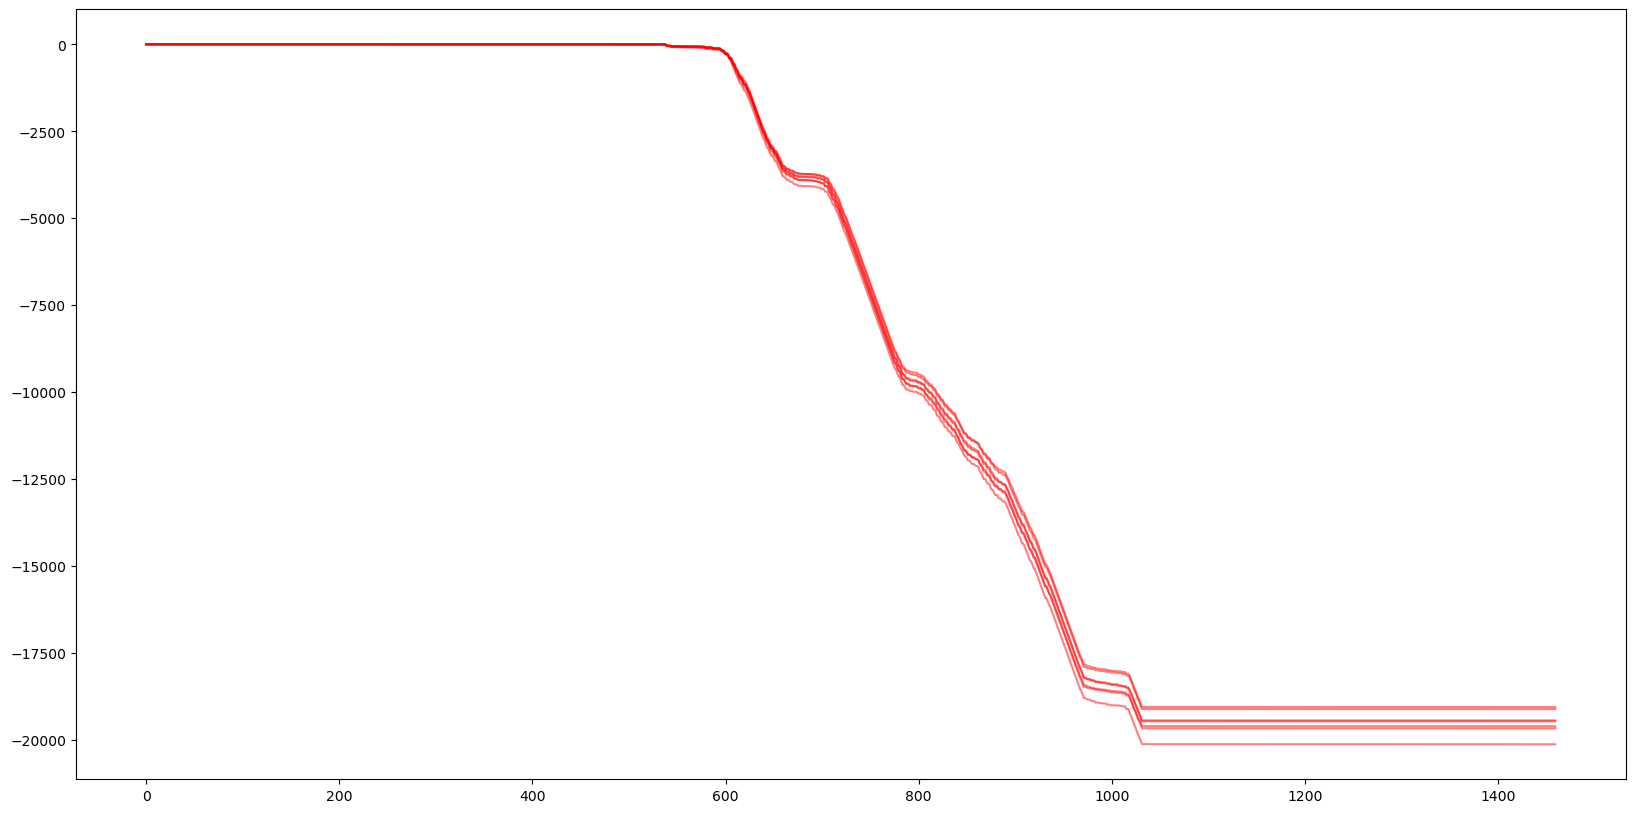

In [63]:
# plot for each building, the borehole cumulative energy flow
# set plot size
plt.figure(figsize=(20, 10))
# set x axis to be the timestep, from 0 to 8760/4
x = range(0, 1460)
# set colormap to be summer
# plt.set_cmap('summer')
borehole_prod_max = 0
borehole_prod_max_idx = ''
for idx, row in energy_cap_df.iterrows():
    model = calliope.read_netcdf(f'./result_site_specific_2/{idx}.nc')
    # try to find the borehole operation data, but if there's no borehole, there will be an error, so use try
    try:
        borehole_prod = model.get_formatted_array('carrier_prod').sel(techs='geothermal_boreholes', 
                                                              carriers='geothermal_storage', 
                                                              locs=idx).to_pandas()
        borehole_con = model.get_formatted_array('carrier_con').sel(techs='geothermal_boreholes',
                                                                    carriers='geothermal_storage',
                                                                    locs=idx).to_pandas()
    except:
        continue
    plt.plot(x, borehole_prod.cumsum()+borehole_con.cumsum(), color='red', alpha=0.5)
    # plt.plot(x, borehole_con.cumsum(), color='blue', alpha=0.5)
    
    # find the largest value of borehole_prod in this loop and report the index of it
    if borehole_prod.max() > borehole_prod_max:
        borehole_prod_max = borehole_prod.max()
        borehole_prod_max_idx = idx
    
print(f'the building with the largest borehole_prod is {borehole_prod_max_idx} with a value of {borehole_prod_max}')
# show the plot
plt.show()